This is the notebook of kaggle competition "House Prices - Advanced Regression Techniques"

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview/description

In [1]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow import keras
# from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
print(keras.__version__)
import tensorflow
print(tensorflow.__version__)

2.7.0
2.7.0


In [2]:
from tensorflow.keras.layers.experimental import preprocessing

In [3]:
import pandas as pd

def load_digits_data(digits_path='data'):
    train_csv_path = os.path.join(digits_path, "train.csv")
    test_csv_path = os.path.join(digits_path, "test.csv")
    return pd.read_csv(train_csv_path), pd.read_csv(test_csv_path)

train, test = load_digits_data()

In [4]:
num_classes = 10
input_shape = (28, 28, 1)

In [5]:
y_train = train['label']

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = train.iloc[:, 1:]
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
train = X_train_scaled.reshape(X_train_scaled.shape[0],28,28,1)
test_scaled = scaler.transform(test.astype(np.float64))
test = test_scaled.reshape(test_scaled.shape[0],28,28,1)

In [7]:
train_aug = np.zeros((train.shape[0]*2, train.shape[1], train.shape[2], train.shape[3]))

In [8]:
train_aug[:train.shape[0],:,:,:] = train.copy()

In [9]:
data_augmentation = tf.keras.Sequential([
#   layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.1),
])

In [10]:
# plt.figure(figsize=(10, 10))
for i in range(train.shape[0]):
    augmented_image = data_augmentation(train[i])
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(augmented_image[0])
#     plt.imshow(augmented_image[:,:,0], cmap=mpl.cm.binary)
#     plt.imshow(train[0, :, :, 0], cmap=mpl.cm.binary)
#     plt.axis("off")
#     print(augmented_image.shape)
#     print(type(augmented_image))
#     print(type(train))
#     print(i)
    train_aug[train.shape[0]+i,:,:,:] = augmented_image.numpy().reshape((1,28,28,1)).copy()
#     train_aug = np.concatenate((train_aug, augmented_image.numpy().reshape((1,28,28,1))), axis=0)
    

In [11]:
train_aug.shape

(84000, 28, 28, 1)

In [12]:
# plt.imshow(train_aug[83999, :, :, 0], cmap=mpl.cm.binary)
# plt.imshow(train_aug[41999, :, :, 0], cmap=mpl.cm.binary)

In [13]:
y_train = pd.concat([y_train, y_train], axis=0, ignore_index=True)

In [14]:
y_train.tail()

83995    0
83996    1
83997    7
83998    6
83999    9
Name: label, dtype: int64

In [15]:
y_binary = to_categorical(y_train.values)

In [16]:
train_aug.shape

(84000, 28, 28, 1)

In [17]:
y_binary.shape

(84000, 10)

In [19]:
model = keras.Sequential([
    layers.InputLayer(input_shape=[28, 28, 1]),
    
#     preprocessing.RandomContrast(factor=0.10),
#     preprocessing.RandomFlip(mode='horizontal'),
#     preprocessing.RandomRotation(factor=0.10),
    
    # Block One
    layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same',
                  input_shape=[28, 28, 1]),
    layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Two
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Three
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

        # Block Three
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Head
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax'),
])


In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_9 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 14, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                  

In [21]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy'],
)

In [22]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(min_delta=0.001, patience=5, restore_best_weights=True)

In [23]:
batch_size = 128
epochs = 50

# model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(train_aug, 
                    y_binary, 
                    batch_size=batch_size, 
                    epochs=epochs, 
#                     callbacks=[early_stopping], 
                    validation_split=0.1)


Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
591/591 [==============================] - ETA: 0s - loss: 1.2382 - categorical_accuracy: 0.5826WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f587c0c4440> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBO

Epoch 38/50
591/591 [==============================] - 79s 134ms/step - loss: 0.0017 - categorical_accuracy: 0.9994 - val_loss: 0.0560 - val_categorical_accuracy: 0.9883
Epoch 39/50
591/591 [==============================] - 80s 136ms/step - loss: 0.0020 - categorical_accuracy: 0.9994 - val_loss: 0.0481 - val_categorical_accuracy: 0.9905
Epoch 40/50
591/591 [==============================] - 86s 145ms/step - loss: 4.6451e-04 - categorical_accuracy: 0.9999 - val_loss: 0.0685 - val_categorical_accuracy: 0.9892
Epoch 41/50
591/591 [==============================] - 77s 131ms/step - loss: 3.7789e-04 - categorical_accuracy: 0.9999 - val_loss: 0.0607 - val_categorical_accuracy: 0.9896
Epoch 42/50
591/591 [==============================] - 97s 163ms/step - loss: 0.0012 - categorical_accuracy: 0.9997 - val_loss: 0.0611 - val_categorical_accuracy: 0.9860
Epoch 43/50
591/591 [==============================] - 77s 131ms/step - loss: 0.0018 - categorical_accuracy: 0.9994 - val_loss: 0.0506 - val_c

(0.95, 1.01)

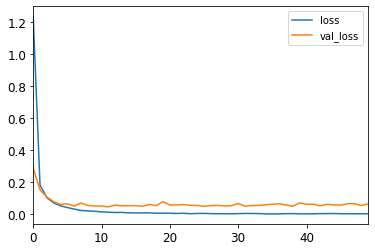

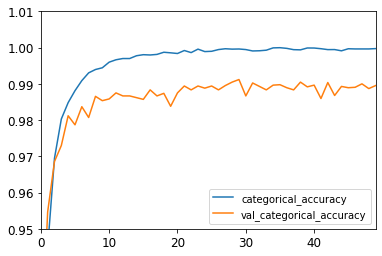

In [24]:
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()
plt.ylim([0.95, 1.01])

In [25]:
predictions = model.predict(test)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [26]:
predictions_cat = predictions.argmax(axis=1)

In [27]:
predictions_cat.shape

(28000,)

In [28]:
sub = pd.DataFrame({'ImageId': list(range(1, len(predictions_cat)+1)), 'Label': predictions_cat})
sub.shape

(28000, 2)

In [29]:
sub.to_csv("data/submission_script14.csv", index=False)